<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LinUCB-:-Implementing-optimism-in-$R^d$" data-toc-modified-id="LinUCB-:-Implementing-optimism-in-$R^d$-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LinUCB : Implementing optimism in $R^d$</a></span></li></ul></div>

In [1]:
import sys
import numpy as np
from scipy.stats import bernoulli
from math import log
import random
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import pinv
import seaborn as sns
import time
import pickle

# Practical Session on Stochastic Linear Bandits :

The architecture of code below provides the environment to run a standard linear bandit experiment. 

## LinUCB : Implementing optimism in $R^d$

* Implement LinUCB as studied in class. In your opinion, what is (are) the bottleneck(s) of this algorithm ? 
* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.
* It is common practice to tweak LinUCB by multiplying the confidence bonus by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?

# Plot Function

In [137]:
## Plot function : 
#-*-coding: utf-8 -*-

current_palette = sns.color_palette()
sns.set_style("ticks")


styles = ['o', '^', 's', 'D', '*', 'x']
colors = current_palette[0:5]+current_palette[6:7]
color_lb = current_palette[4]

algos = {'LinUCB_Li': 'LinUCB_Li',
         'LinUCB_naive': 'LinUCB_naive',
         'LinUCB_naive_optim': 'LinUCB_naive_optim',
         'LinUCB': 'LinUCB',
         'Unif': 'Unif'}

def plot_regret(data, tsav, filename, log=False, taum=False,
                freq=50, qtl=False, label_param=False):
    fig = plt.figure(figsize=(7, 6))
    Nsub = len(tsav)
    T = len(data[0][1]) # length of regret
    N_curves = len(data)
    if log == True:
        plt.xscale('log')
        markevery = 1. / 12
        freq = 1
    i = 0
    
    for key, regret, avgRegret, qRegret, QRegret in data:
        T = len(regret)
        if qtl:
            if label_param :
                if(type(alpha) is list):
                    label = "alpha="+str(alpha[i])
                if(type(lmbda) is list):
                    label = "lambda="+str(lmbda[i])
                if(type(delta) is list):
                    label = "delta="+str(delta[i])
            else : 
                label = algos[key] # r"\textbf{%s}" % 
            plt.plot(tsav, avgRegret, marker=styles[i], markevery=4,
                     ms=10.0, label=label, color=colors[i])
            plt.fill_between(tsav, qRegret, QRegret, alpha=0.15, 
                             linewidth=1.5, color=colors[i])
        else:
            if label_param :
                if(len(alpha)>1):
                    label = "alpha="+str(alpha[i])
                if(len(lmbda)>1):
                    label = "lambda="+str(lmbda[i])
                if(type(delta) is list):
                    label = "delta="+str(delta[i])
            else : 
                label = algos[key] # r"\textbf{%s}" %
            plt.plot(np.arange(len(regret))[0::freq], regret[0::freq],
                     marker=styles[i], ms=10.0,
                     label=label, color=colors[i])
        i += 1

    plt.legend(loc=2)
    plt.xlabel('Round t', fontsize=20)
    plt.ylabel('Regret R(T)', fontsize=18)
        
    plt.savefig('%s.pdf' % (filename), bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return

# Action generators 

In [3]:
def randomActionsGenerator(K,d):
  """
  K: int -- number of action vectors to be generated
  d : int -- dimension of the action space
  returns : an array of K vectors uniformly sampled on the unit sphere in R^d
  """

  vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size =K)
  norms = np.linalg.norm(vecs,axis=1)
  return vecs / norms[:,np.newaxis]

In [4]:
a = randomActionsGenerator(100,2)
print(a.shape)

(100, 2)


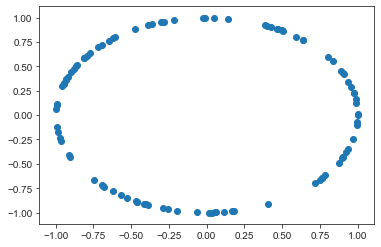

In [5]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

In [6]:
class Environment:
  """
    Parameters:
    -----------
    K:  int
        Number of arms generated at each round

    d: int
        Dimension of the problem

    theta: d-dimensional vector
        Key hidden parameter of the problem


    """

  def __init__(self, d, K, theta):
    self.theta = theta
    self.d = d
    self.K = K

  def play(self, chosen_arm):
    """Play the arm with index choice and returns the corresponding reward:

        expected_reward + gaussian_noise
        """

    expected_reward = np.dot(chosen_arm, self.theta)
    reward = np.random.normal(expected_reward)

    return chosen_arm, expected_reward, reward

  def getBestArm(self, arms):
    """Return the index of the best arm and the corresponding expected payoff"""
    payoffs = np.zeros(self.K)
    for i in range(self.K):
      payoffs[i] = np.dot(arms[i,:], self.theta)

    bestArm = np.argmax(payoffs)
    return bestArm, payoffs[bestArm]

# Simulator

In [7]:
class Simulator():
  """
    Simulator of stochastic delayed games.

    Params:
    -------

    policies: list
        List of policies to test.

    K: int
        Number of arms to be generated at each round

    d: int
        Dimension of the problem

    """

  def __init__(self, environment, policies, K, d):
    self.env = environment
    self.policies = policies
    self.d = d
    self.K = K

  def run(self, T, N, q, tsav):
    """Runs an experiment with parameters T and N.

        It returns a dictionary whose keys are policies and whose values
        are the regret obtained by these policies over the experiments and
        averaged over N runs.qRegret and QRegret are the first and third quartiles.

        Parameters
        ----------
        T: int
            Length of the sequential allocations.

        N: int
            Number of Monte Carlo repetitions.

        q: int
            Quantile parameter (e.g. 25 -> quartiles)

        tsav: numpy array (ndim = 1)
            Points to save on each trajectory.
        """
    regret, cumRegret, N_plays = dict(), dict(), dict()
    Nsub = np.size(tsav)  # Number of points saved for each trajectory
    avgRegret, qRegret, QRegret = dict(), dict(), dict()

    for policy in self.policies:
      name = policy.id()
      cumRegret[name] = np.zeros((N, Nsub))
      regret[name] = np.zeros(T)
    
    avg_time = np.zeros(len(policies))
    for nExp in range(N):

      if N < 10 or nExp % (N / 5) == 0:
        print("experiments executed:", nExp)
        sys.stdout.flush()
      
      i = 0
      for policy in self.policies:
        name = policy.id()
        # Reinitialize the policy
        policy.init()
        optimalRewards = np.zeros(T)
        rewards = np.zeros(T)

        # We follow the policy
        for t in range(T):

          # get arms, play one of them (policy), get reward:
          availableArms = randomActionsGenerator(self.K,self.d) 
          t0 = time.time()
          A_t = policy.selectArm(availableArms, self.K)
          t1 = time.time()
          chosen_arm, expected_reward, reward = self.env.play(availableArms[A_t,:])

          #update the policy:
          policy.updateState(chosen_arm,reward)

          #compute instant pseudo regret
          instantBestArm, instantBestReward = self.env.getBestArm(availableArms)
          optimalRewards[t] += instantBestReward
          rewards[t] += expected_reward
          
          #For time comparison between policies
          avg_time[i] += (t1-t0)

        regret[name] += (optimalRewards - rewards) 
        cumRegret[name][nExp] += np.cumsum(optimalRewards - rewards)[tsav]
        i += 1

    print("build data out of the experiments")
    i = 0
    for policy in self.policies:
      name = policy.id()
      print("Average computation time for policy "+str(name)+" to select the best arm is : "+str(avg_time[i]/(T*nExp)))
      regret[name] = np.cumsum(regret[name]) / N
      cumReg = cumRegret[name]
      avgRegret[name] = np.mean(cumReg, 0)
      qRegret[name] = np.percentile(cumReg, q, 0)
      QRegret[name] = np.percentile(cumReg, 100 - q, 0)
      i+=1

    print("data built")
    return regret, avgRegret, qRegret, QRegret

# Policies

In [8]:
class Policy(object):

  def __init__(self, K, T):
    """
        Constructor.
        """
    raise NotImplementedError("Method `__init__` is not implemented.")

  def selectArm(self):
    """
        This functions selects L arms among the K ones depending on statistics
        over the past observations.
        """
    raise NotImplementedError("Method `selectArms` is not implemented.")

  def updateState(self):
    """
        This function updates the statistics given the new observations.
        """
    raise NotImplementedError("Method `updateState` is not implemented.")

  def init(self):
    """
        This function updates the statistics given the new observations.
        """
    raise NotImplementedError("Method `updateState` is not implemented.") 

  #@staticmethod
  def id(self):
    raise NotImplementedError("Static method `id` is not implemented.")

In [22]:
## Policies :
class Uniform(Policy):
  def __init__(self, T,d):
    pass

  def selectArm(self, arms, K):
    return np.random.choice(K)

  def updateState(self, chosen_arm, reward):
    pass

  def init(self):
    pass

  #@staticmethod
  def id(self):
    return 'Unif'

# This policy implement the LinUCB algorithm as it was written in the Section 3.1
# of the following paper by Li et al.2010 : http://rob.schapire.net/papers/www10.pdf
class LinUCB_Li(Policy):

  def __init__(self, d, K, alpha):
    self.d = d
    self.alpha = alpha
    self.K = K
    self.index = -1

  def init(self):
    #INIT A et b
    self.A = [np.identity(self.d)]*self.K
    self.b = [np.zeros(self.d)]*self.K

  def selectArm(self, arms, K):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
    theta = [np.zeros(self.d)]*K
    payoff = np.zeros(K)
    for arm in range(K):
        theta[arm] = pinv(self.A[arm]) @ self.b[arm]
        payoff[arm] = theta[arm] @ arms[arm] + self.alpha * np.sqrt(np.transpose(arms[arm])@pinv(self.A[arm])@arms[arm])
    
    arm = np.argmax(payoff)
    self.index = arm
    return(arm)
    
  def updateState(self, chosen_arm, reward):
    #MAJ A et b
    self.A[self.index] += chosen_arm @ np.transpose(chosen_arm)
    self.b[self.index] += reward * chosen_arm

  def id(self):
    return "LinUCB_Li"


# This policy implement the LinUCB algorithm as seen in the slides
class LinUCB_naive(Policy):

  def __init__(self, d, K, alpha, lmbda, delta):
    self.lmbda = lmbda
    self.delta = delta
    self.d = d
    self.K = K
    self.alpha = alpha
    #dropping the loglog(t) term for now

  def init(self):
    self.t = 0
    self.V = self.lmbda*np.eye(self.d)
    self.b = np.zeros(self.d)
    self.Beta = self.alpha*(np.sqrt(self.lmbda) + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lmbda*self.d)/(self.lmbda))))
     

  def selectArm(self, arms, K):
    
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
    V_inv = pinv(self.V)
    theta_ = np.matmul(V_inv,np.transpose(self.b))
    payoff = [np.matmul(arms[i],theta_) + np.sqrt(self.Beta*(np.matmul(np.transpose(arms[i]),np.matmul(V_inv,arms[i])))) for i in range(self.K)]
    return np.argmax(payoff)
    

  def updateState(self, chosen_arm, reward):
    self.V += np.outer(np.transpose(chosen_arm),chosen_arm)
    self.b += chosen_arm * reward
    self.t += 1
    self.Beta = self.alpha*(np.sqrt(self.lmbda) + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lmbda*self.d + self.t)/(self.lmbda))))


  def id(self):
    return "LinUCB_naive"

* In your opinion, what is (are) the bottleneck(s) of this algorithm ?

The algorithm seen in the slides enable us to have a guaranteed maximal regret, which is not possible with the Li and al.2010 algorithm, because of the hyperparameter alpha.

More generally, the bottlenecks of the LinUCB algorithm are that we need to choose carefully the confidence interval, and is pretty complex in terms of computation complexity. Is is also dependent on the initialization values of some parameters, like lambda and delta.

# main

In [101]:
d = 15  # dimension
K = 30  # number of arms
T = 5000  # Finite Horizon
N = 10  # Monte Carlo simulations
delta = 0.1 #Beta_t parameter
alpha = 1 #Hyperparameter
lmbda = 1 #V initialization parameter

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

# Policies to evaluate
policies = [LinUCB_Li(d, K, alpha),
            LinUCB_naive(d, K, alpha, lmbda, delta), 
            Uniform(T,d)]
# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub) 

def main(N, T, d, K, alpha, delta, lmbda, policies):
  #choice of quantile display
  q = 10

  # Create an object of K arms with delayed feedback with mean delay tau
  env = Environment(d, K, theta)

  simulator = Simulator(env, policies, K, d)

  regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)
  
  data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
  ] for policy in avgRegret]

  return data

In [24]:
%%time
#Let's run the experiment with the 3 policies
data = main(N, T, d, K, alpha, delta, lmbda, policies)

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_Li to select the best arm is : 0.007287953233718872
Average computation time for policy LinUCB_naive to select the best arm is : 0.0005115239037407769
Average computation time for policy Unif to select the best arm is : 1.6759437984890408e-05
data built
CPU times: user 6min 35s, sys: 2.69 s, total: 6min 37s
Wall time: 6min 44s


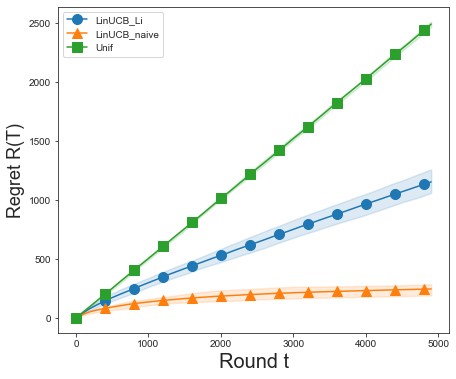

In [25]:
#Let's plot the regret over the experiments for each policy
freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)

Without using any hyperparameter, we see that both LinUCB are better than the Uniform policy. In fact, the LinUCB seen in class gives a much better perfomance in time than the LinUCB proposed by Li and al.2010. 

It can be explained for 2 reasons : 
* First, I could have done a bad implemetation of it. As I understood it, we had to compute a matrix A and a vector b for each arm, whereas in the LinUCB seen in class we only use one matrix V and one vector b for every arms.
* Secondly, the LinUCB initially proposed by Li and al.2010 does not guarantee a theoretical maximum regret, while the LinUCB seen in class guarantee a maximum regret. 
* Finally, we didn't play with the alpha parameter presented in the LinUCB of Li and al.2010, setting it to 1. We could achieve better performance with a fine setting of alpha.

* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.

We Are Looking for a Matrix C such that :

<math>\begin{align}
  I &= \left(A + uv^\textsf{T}\right)C \\[6pt] I &=  C \left(A + uv^\textsf{T}\right) \\
\end{align}</math>


We would like C to be as simple as possible and relying only on C and uvT : 

<math>\begin{align}
  C &= \left(A^{-1} + B\right) \\[6pt] 
\end{align}</math>

Let us write the first equation : 

<math>\begin{align}
  I &= \left(A + uv^\textsf{T}\right)\left(A^{-1} + B\right) \\[6pt]
  &= AA^{-1} + uv^\textsf{T}A^{-1} + {AB} + uv^\textsf{T}B \\[6pt]
  &= I + uv^\textsf{T}A^{-1} + {AB} + uv^\textsf{T}B \\[6pt]
\end{align}</math>

Then 

<math>\begin{align}
      0&= A^{-1}uv^\textsf{T}A^{-1} + {B} + A^{-1}uv^\textsf{T}B \\[6pt]
      0&= v^\textsf{T}A^{-1}uv^\textsf{T}A^{-1} + v^\textsf{T}{B} + v^\textsf{T}A^{-1}uv^\textsf{T}B \\[6pt]
      0&= v^\textsf{T}A^{-1}uv^\textsf{T}A^{-1} + (1 + v^\textsf{T}A^{-1}u)v^\textsf{T}B \\[6pt]
\end{align}</math>

i.e we have 

<math>\begin{align}
      -v^\textsf{T}A^{-1}uv^\textsf{T}A^{-1} &=  (1 + v^\textsf{T}A^{-1}u)v^\textsf{T}B \\[6pt]
     {-v^\textsf{T}A^{-1}uv^\textsf{T}A^{-1}\over 1 + v^\textsf{T}A^{-1}u} &= v^\textsf{T}B \\[6pt]
     {-A^{-1}uv^\textsf{T}A^{-1}\over 1 + v^\textsf{T}A^{-1}u} &= B \\[6pt]
\end{align}</math>

So, in a nutshell we can compute the inverse of the sum A + uvT by using the Matrix C such that :

<math>\begin{align}
      C &=  (A^{-1} -{A^{-1}uv^\textsf{T}A^{-1}\over 1 + v^\textsf{T}A^{-1}u})  \\[6pt]
\end{align}</math>

This allows us to compute only the inverse of the past iteration V matrix, enabling us to gain some time due to the easier computation.

In [13]:
#Function to recursively compute the inverse of A
def inv_optim(A, u, v):
    out = np.outer(u,np.transpose(v))
    x =  np.matmul(A, np.matmul(out, A))
    y =  1 + np.matmul(np.transpose(v),np.matmul(A,u))
    return(A - x/y)

In [30]:
#Let's redefine the naive LinUCB
# This policy implement the LinUCB algorithm as seen in the slides
class LinUCB_naive(Policy):
  #Let's add an hyperparameter for the following question
  def __init__(self, d, K, alpha, lmbda, delta):
    self.lmbda = lmbda
    self.delta = delta
    self.alpha = alpha
    self.d = d
    self.K = K
    self.index = -1

  def init(self):
    #INIT V et b
    self.t = 0
    self.V = self.lmbda*np.eye(self.d)
    self.V_inv = (1/self.lmbda)*np.eye(self.d)
    self.b = np.zeros(self.d)
    self.Beta = self.alpha*(np.sqrt(self.lmbda) + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lmbda*self.d)/(self.lmbda))))

  def selectArm(self, arms, K):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
    theta_ = np.matmul(self.V_inv, np.transpose(self.b))
    payoff = [np.matmul(arms[i],theta_) + np.sqrt(self.Beta*(np.matmul(np.transpose(arms[i]),np.matmul(self.V_inv, arms[i])))) for i in range(self.K)]
    return np.argmax(payoff)
    

  def updateState(self, chosen_arm, reward):
    #Let's add a class attribute to compute by recurrence the inverse of V
    self.V += np.outer(np.transpose(chosen_arm), chosen_arm)
    self.V_inv = inv_optim(self.V_inv, chosen_arm, chosen_arm)
    self.b += chosen_arm * reward
    self.t += 1
    self.Beta = self.alpha*(np.sqrt(self.lmbda) + np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.lmbda*self.d + self.t)/(self.lmbda))))

  def id(self):
    return "LinUCB_naive_optim"

Let's re-run the simulation with the same parameters, to see if this method is quicker : 

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_Li to select the best arm is : 0.0076334019978841145
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.0002868778864542643
data built


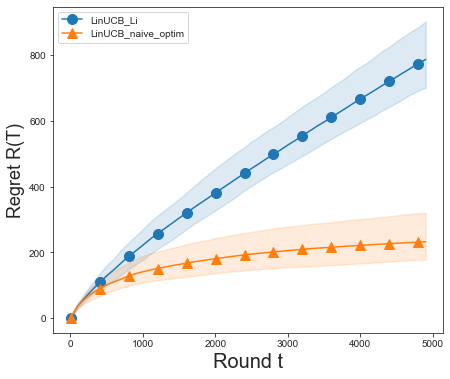

CPU times: user 6min 26s, sys: 2.97 s, total: 6min 29s
Wall time: 6min 37s


In [20]:
%%time

policies = [LinUCB_Li(d, K, alpha),
            LinUCB_naive(d, K, alpha, lmbda, delta)]

data = main(N, T, d, K, alpha, delta, lmbda, policies)

freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)

We have measured the average time over nExp * T plays plays for the policies to select the best arm. 
* With the first LinUCB non optimized (where we had to compute the inverse of V), the average time to select the best arm was : 500 micro seconds
* With the optimized LinUCB, the average time to select the best arm was : 300 micro seconds

It seems like the time difference is not a big deal, but this is just the diffreence for one iteration. For 10 * 5000 = 50000 plays, we have a significant improvement by 50000 * 200 = 10 seconds to select the best arm.

* It is common practice to tweak LinUCB by multiplying the confidence bonus by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?

Alpha is kind of a learning parameter. It is here to adjust the balance between exploration and exploitation. In fact the bigger the alpha the bigger the exploration will be.

This trick is a good idea, because it enables to control the exploration. But we need to choose its value carefully because if we explore too much, we will never exploit the best startegies possible. Moreover, if we exploit too much, there is a risk not to find the optimal strategy.

That is why such hyperparameter doesn't guarantee a maximal bound on the regret. With a good setting, we can have a better regret than the theoretical best regret in the case without the hyperparameter, but this is not guaranteed. We could prefer a regular LinUCB since the maximal bound of regret is guaranteed.

In [129]:
#Now, let's play with the alpha parameter
alpha = [1, 0.5, 0.2, 0.1, 0.05, 0.01]

data_plot = []
for alp in alpha : 
    policies = [LinUCB_naive(d, K, alp, lmbda, delta)]
    data = main(N, T, d, K, alpha, delta, lmbda, policies)
    data_plot.append(data[0])

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.00029186776479085284
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.00027281182607014976
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.00028752473725212946
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for poli

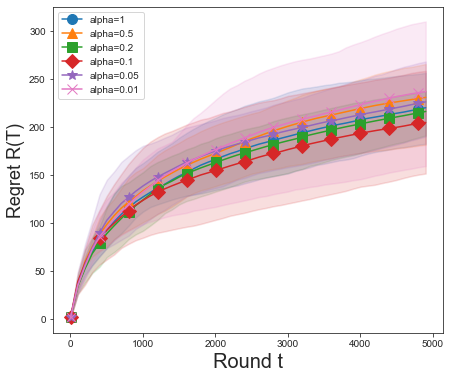

In [130]:
freq = 10
plot_regret(
    data_plot,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True,
    label_param=True)

We can conclude that the best alpha is 0.1
Let's do the same thing for lambda, which is the regularization parameter.

In [131]:
alpha = 0.1
lmbda = [1, 0.5, 0.2, 0.1, 0.05, 0.01]

data_plot = []
for lbd in lmbda : 
    policies = [LinUCB_naive(d, K, alpha, lbd, delta)]
    data = main(N, T, d, K, alpha, delta, lmbda, policies)
    data_plot.append(data[0])

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.0002849515279134115
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.0002879444970024957
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.0002974981255001492
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy 

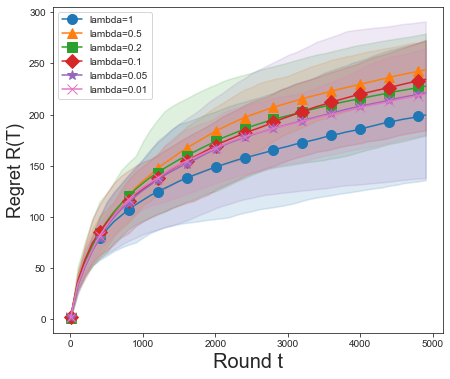

In [135]:
freq = 10
plot_regret(
    data_plot,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True,
    label_param=True)

We can see that the best lambda is in fact the biggest one (value 1). The best strategy seems to be exploring at the beginning with this high value of regularization. 
Let's do the same with the delta parameter which is the confidence level.

In [136]:
alpha = 0.1
lmbda = 1
delta = [1, 0.5, 0.2, 0.1, 0.05, 0.01]

data_plot = []
for delt in delta : 
    policies = [LinUCB_naive(d, K, alpha, lmbda, delt)]
    data = main(N, T, d, K, alpha, delta, lmbda, policies)
    data_plot.append(data[0])

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.00030064585473802357
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.00029835869471232096
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.00029360834227667917
data built
experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for poli

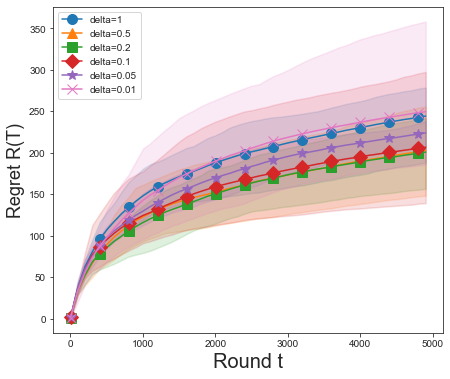

In [139]:
freq = 10
plot_regret(
    data_plot,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True,
    label_param=True)

So the best delta seems to be 0.2.
Finally, the best model is achieved with parameters : 
* alpha = 0.1
* lambda = 1
* delta = 0.2


In [140]:
# Let's plot the final best model
alpha = 0.1
lmbda = 1
delta = 0.2

# Policies to evaluate
policies = [LinUCB_Li(d, K, alpha),
            LinUCB_naive(d, K, alpha, lmbda, delta), 
            Uniform(T,d)]

data = main(N, T, d, K, alpha, delta, lmbda, policies)

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
Average computation time for policy LinUCB_Li to select the best arm is : 0.006648852570851644
Average computation time for policy LinUCB_naive_optim to select the best arm is : 0.0002696761343214247
Average computation time for policy Unif to select the best arm is : 1.4495012495252821e-05
data built


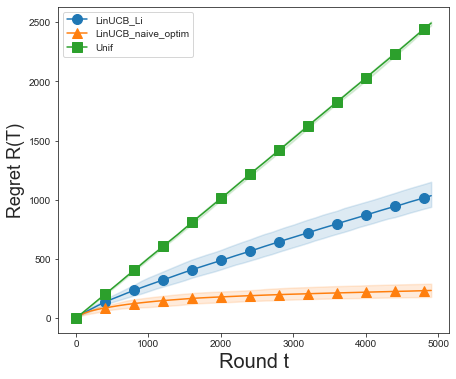

In [141]:
freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)